In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
# choose the size of your minibatch
batch_size = 32

device = 'cpu'
# to run on GPU, uncomment the following line:
#device = 'cuda:0'

We will train a deep convolutional neural network on the MNIST dataset. It consists of 70,000 images (60,000 for training and 10,000 for testing) of hand written digits. Our task is to predict the digit represented by each image.

# Load the data 

Note the normalisation (remove the mean, divide by the std).

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

# Let's visualise the data

In [4]:
batch, labels = next(iter(train_loader))

This gives us a batch of images and the corresponding labels (the class each sample belongs to).
batch has (batch_size, n_channels, height, width) and labels is simply of shape (batch_size, ).
Since the samples of MNIST are black and white images, n_channels is 1, let's remove it.

In [5]:
batch = batch.squeeze()  # By default, removes the dimensions of size 1

ToTensor() converts the images from uint8 (values from 0 to 255) to float32 (ranging from 0 to 1). We typically would need to convert them back to uint8 images to properly visualise them. However, in this case, since they are just grayscale images, we don't have to.

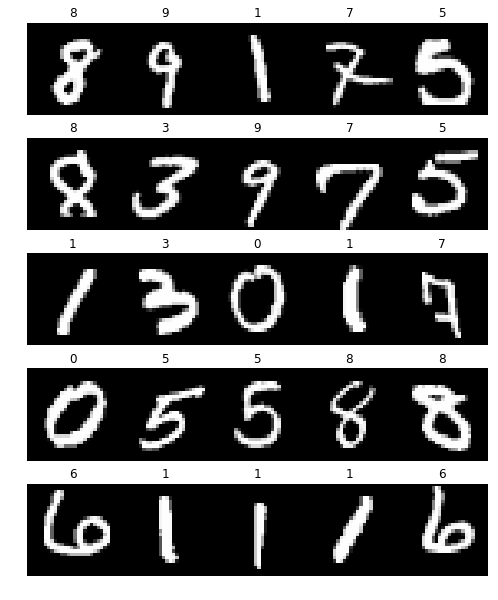

In [6]:
n_columns = 5
n_rows = 5
fig = plt.figure(figsize=(8, 8))
index = 0
for row in range(n_rows):
    for column in range(n_columns):
        ax = fig.add_subplot(n_rows, n_columns, index+1)
        ax.imshow(batch[index].detach().cpu().numpy(), cmap=plt.cm.Greys_r)
        ax.set_axis_off()
        ax.set_title(labels[index].item())
        index += 1
plt.subplots_adjust(top = 1, bottom = 0, right = 0.8, left = 0, 
        hspace = 0, wspace = 0)
plt.show()


# Define the net

Our network will be composed of a series of two convolutions, pooling, non-linearity, followed by a flattening and fully-connected layer.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10) # We output log-probabilities for 10 classes

    def forward(self, x):
        # the input is (bs, 1, 28, 28)
        x = self.conv1(x) # Loose 2 pixels on each side
        
        # x is now (bs, 10, 24, 24)
        x = F.max_pool2d(x, 2) # divide resolution  by two
        x = F.relu(x)
        
        x = self.conv2(x)
        # x is (bs, 20, 8, 8)
        
        x = F.max_pool2d(x, 2)
        # x is (bs, 20, 4, 4)
        x = F.relu(x)
        
        x = x.view(-1, 320) 
        # we flattened x (320 = 20*4*4)
        
        x = F.relu(self.fc1(x))
        # x is (bs, 50)
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        # x is (bs, 10)
        return F.log_softmax(x, dim=1)


model = Net()

In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion=nn.CrossEntropyLoss()

In [9]:
n_epoch = 5 # Number of epochs

model = model.to(device)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Send the data and label to the correct device
        data, target = data.to(device), target.to(device)
        
        # Important: do not forget to reset the gradients
        optimizer.zero_grad()
        
        # Pass the data through the networks
        output = model(data)
        
        # Compute the loss
        loss = criterion(output,target)
        
        # Backprogragate the gradient
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # That's just printing some info...
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss = criterion(output,target)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('mean: {}'.format(test_loss))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))


for epoch in range(n_epoch):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.278881
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.547932
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.056793
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.103723
mean: 6.5000408540072385e-06

Test set: Average loss: 0.0000, Accuracy: 9819/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.124601
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.056968
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.013600
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.022261
mean: 9.150053301709704e-07

Test set: Average loss: 0.0000, Accuracy: 9852/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.099478
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.146930
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.113602
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.140082
mean: 1.9702911302488246e-08

Test set: Average loss: 0.0000, Accuracy: 9880/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.022954
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.029932
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.052703
T